# Giesekus LAOS: Large-Amplitude Oscillatory Shear

## Learning Objectives

1. Generate synthetic LAOS data from calibrated Giesekus parameters
2. Construct and interpret Lissajous-Bowditch curves
3. Extract Fourier harmonics (I₁, I₃, I₅) from stress response
4. Understand how Weissenberg number Wi = λω affects nonlinearity
5. Observe the effect of α on LAOS signatures

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- NB 01: Giesekus flow curve (provides calibrated parameters)

## Runtime

- Fast demo: ~5-10 minutes (ODE integration is slower)
- Full run: ~20-30 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import json
import os
import time as time_module
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.fft import fft, fftfreq

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Large-Amplitude Oscillatory Shear

### The Experiment

In LAOS, we apply a sinusoidal strain:
$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

where γ₀ is the strain amplitude (typically 0.1 to 10) and ω is the angular frequency.

### Linear vs Nonlinear Response

**SAOS (Small Amplitude):** For γ₀ << 1, the stress is sinusoidal:
$$
\sigma(t) = \gamma_0 [G'(\omega) \sin(\omega t) + G''(\omega) \cos(\omega t)]
$$

**LAOS (Large Amplitude):** For γ₀ ~ O(1), higher harmonics appear:
$$
\sigma(t) = \gamma_0 \sum_{n=1,3,5,...} [G'_n \sin(n\omega t) + G''_n \cos(n\omega t)]
$$

Only **odd harmonics** appear due to symmetry.

### Key LAOS Metrics

| Metric | Definition | Physical Meaning |
|--------|------------|------------------|
| I₁ | Fundamental amplitude | Linear response |
| I₃/I₁ | Third harmonic ratio | Nonlinearity onset |
| I₅/I₁ | Fifth harmonic ratio | Strong nonlinearity |
| Q₀ | I₃/(I₁·γ₀²) | Intrinsic nonlinearity |

### Lissajous-Bowditch Curves

- **Elastic Lissajous**: σ vs γ (tilted ellipse in linear regime)
- **Viscous Lissajous**: σ vs γ̇ (rotated view)

Deviation from ellipse indicates nonlinearity.

### Giesekus LAOS

The quadratic τ·τ term generates odd harmonics. Higher α leads to:
- Stronger third harmonic I₃
- More pronounced Lissajous distortion

## 3. Load Calibrated Parameters

In [3]:
# Try to load parameters from NB01
param_file = os.path.join("..", "outputs", "giesekus", "flow_curve", "nlsq_params_flow_curve.json")

if os.path.exists(param_file):
    with open(param_file) as f:
        calibrated_params = json.load(f)
    print("Loaded calibrated parameters from NB01:")
else:
    calibrated_params = {
        "eta_p": 100.0,
        "lambda_1": 1.0,
        "alpha": 0.3,
        "eta_s": 10.0,
    }
    print("Using default parameters (run NB01 for calibrated values):")

for k, v in calibrated_params.items():
    print(f"  {k}: {v:.4g}")

lambda_1 = calibrated_params["lambda_1"]
alpha = calibrated_params["alpha"]

Loaded calibrated parameters from NB01:
  eta_p: 3.168e+04
  lambda_1: 1534
  alpha: 0.2093
  eta_s: 0.2815


## 4. Generate Synthetic LAOS Data

In [4]:
# Create model with calibrated parameters
model = GiesekusSingleMode()
for name, val in calibrated_params.items():
    model.parameters.set_value(name, val)

# LAOS parameters
gamma_0 = 1.0  # Strain amplitude (large)
omega = 1.0    # Angular frequency (rad/s)
n_cycles = 10  # Number of oscillation cycles
n_points_per_cycle = 100

# Dimensionless numbers
Wi = lambda_1 * omega
De = lambda_1 * gamma_0 * omega  # Deborah number

print(f"LAOS parameters:")
print(f"  γ₀ = {gamma_0} (strain amplitude)")
print(f"  ω = {omega} rad/s")
print(f"  Wi = λω = {Wi:.2f}")
print(f"  De = λγ₀ω = {De:.2f}")

LAOS parameters:
  γ₀ = 1.0 (strain amplitude)
  ω = 1.0 rad/s
  Wi = λω = 1533.90
  De = λγ₀ω = 1533.90


In [5]:
# Generate time array
period = 2 * np.pi / omega
t_end = n_cycles * period
n_total = n_cycles * n_points_per_cycle
time = np.linspace(0.01, t_end, n_total)

# Compute strain and strain rate
strain = gamma_0 * np.sin(omega * time)
strain_rate = gamma_0 * omega * np.cos(omega * time)

# Simulate LAOS stress
print("Simulating LAOS response (this may take a moment)...")
t0 = time_module.time()
result = model.simulate_laos(time, gamma_0=gamma_0, omega=omega, n_cycles=n_cycles)
t_sim = time_module.time() - t0
print(f"Simulation time: {t_sim:.1f} s")

# Extract stress
if isinstance(result, dict):
    stress = np.array(result.get("stress", result.get("sigma", np.zeros_like(time))))
else:
    stress = np.array(result)

# Ensure same length
if len(stress) != len(time):
    stress = np.interp(time, np.linspace(0, t_end, len(stress)), stress)

Simulating LAOS response (this may take a moment)...


Simulation time: 16.9 s


In [6]:
# Add noise (3%)
rng = np.random.default_rng(42)
noise_level = 0.03
noise = rng.normal(0, noise_level * np.std(stress), size=stress.shape)
stress_noisy = stress + noise

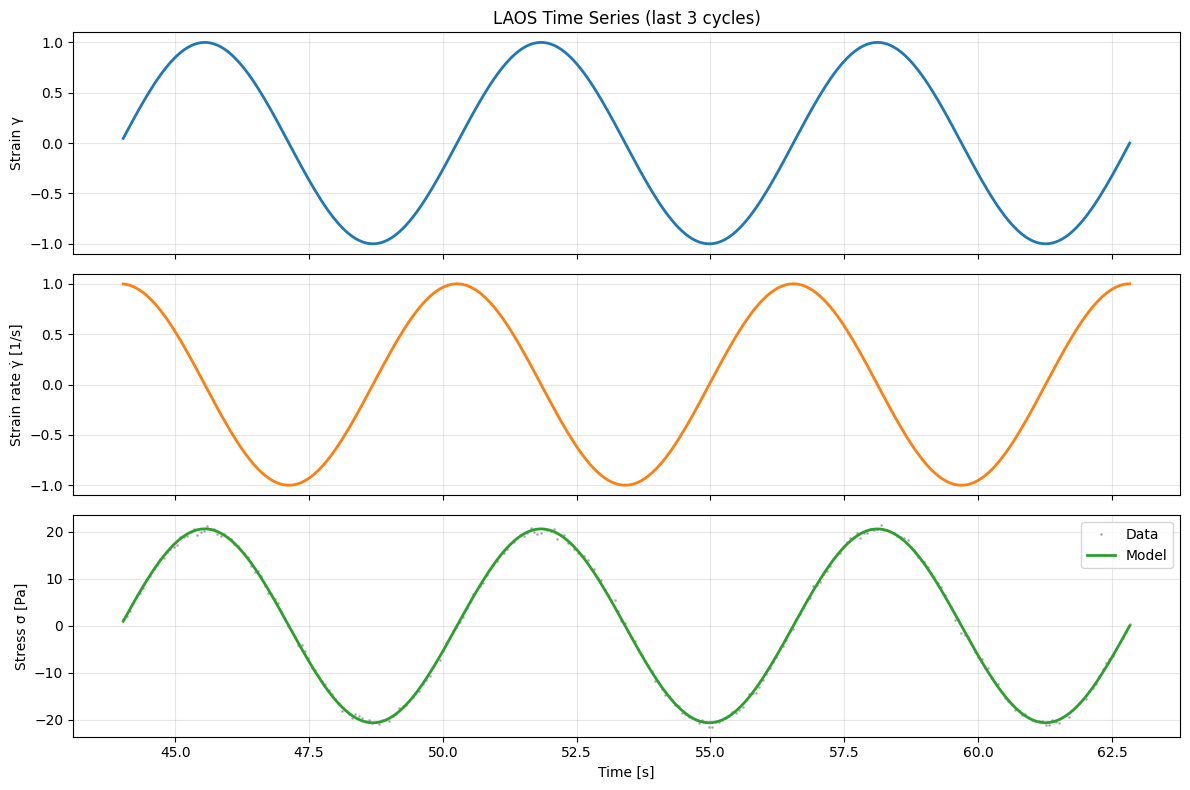

In [7]:
# Plot time series
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Last 3 cycles for clarity
t_start = (n_cycles - 3) * period
mask = time >= t_start

axes[0].plot(time[mask], strain[mask], "-", lw=2, color="C0")
axes[0].set_ylabel("Strain γ")
axes[0].set_title("LAOS Time Series (last 3 cycles)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(time[mask], strain_rate[mask], "-", lw=2, color="C1")
axes[1].set_ylabel("Strain rate γ̇ [1/s]")
axes[1].grid(True, alpha=0.3)

axes[2].plot(time[mask], stress_noisy[mask], ".", markersize=2, color="gray", alpha=0.5, label="Data")
axes[2].plot(time[mask], stress[mask], "-", lw=2, color="C2", label="Model")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Stress σ [Pa]")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Lissajous-Bowditch Curves

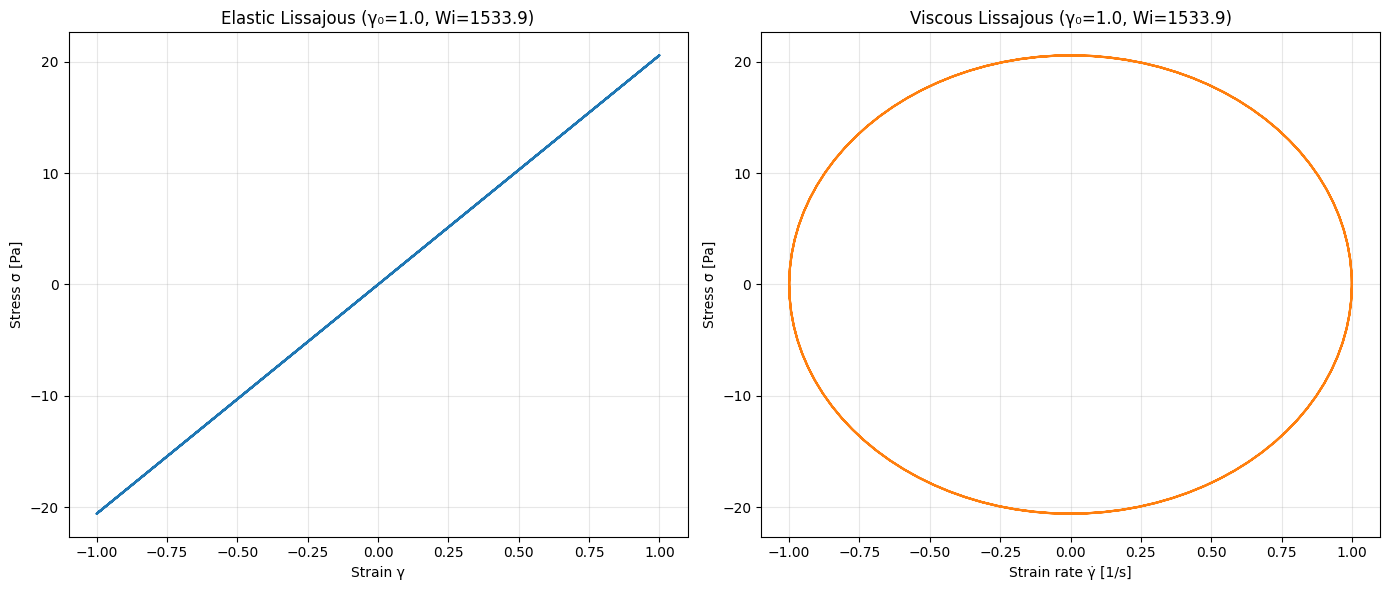

Lissajous interpretation:
  - Perfect ellipse = linear viscoelastic
  - Deviation from ellipse = nonlinear response
  - S-shape or figure-8 = strong nonlinearity


In [8]:
# Use steady-state cycles (last 3)
t_ss = (n_cycles - 3) * period
mask_ss = time >= t_ss

strain_ss = strain[mask_ss]
strain_rate_ss = strain_rate[mask_ss]
stress_ss = stress[mask_ss]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Elastic Lissajous: σ vs γ
ax1.plot(strain_ss, stress_ss, "-", lw=1.5, color="C0")
ax1.set_xlabel("Strain γ")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title(f"Elastic Lissajous (γ₀={gamma_0}, Wi={Wi:.1f})")
ax1.grid(True, alpha=0.3)
ax1.set_aspect("auto")

# Viscous Lissajous: σ vs γ̇
ax2.plot(strain_rate_ss, stress_ss, "-", lw=1.5, color="C1")
ax2.set_xlabel("Strain rate γ̇ [1/s]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title(f"Viscous Lissajous (γ₀={gamma_0}, Wi={Wi:.1f})")
ax2.grid(True, alpha=0.3)
ax2.set_aspect("auto")

plt.tight_layout()
display(fig)
plt.close(fig)

print("Lissajous interpretation:")
print("  - Perfect ellipse = linear viscoelastic")
print("  - Deviation from ellipse = nonlinear response")
print("  - S-shape or figure-8 = strong nonlinearity")

## 6. Fourier Harmonic Extraction

In [9]:
# Extract harmonics from one steady-state cycle
cycle_start = (n_cycles - 1) * n_points_per_cycle
cycle_end = n_cycles * n_points_per_cycle
stress_cycle = stress[cycle_start:cycle_end]
time_cycle = time[cycle_start:cycle_end] - time[cycle_start]

# FFT
n = len(stress_cycle)
stress_fft = fft(stress_cycle)
freqs = fftfreq(n, d=(time_cycle[1] - time_cycle[0]))

# Find fundamental frequency index
fundamental_freq = omega / (2 * np.pi)
freq_idx = np.argmin(np.abs(freqs - fundamental_freq))

# Extract harmonics
I1 = 2 * np.abs(stress_fft[freq_idx]) / n
I3_idx = np.argmin(np.abs(freqs - 3 * fundamental_freq))
I3 = 2 * np.abs(stress_fft[I3_idx]) / n
I5_idx = np.argmin(np.abs(freqs - 5 * fundamental_freq))
I5 = 2 * np.abs(stress_fft[I5_idx]) / n

print("Fourier Harmonics")
print("=" * 40)
print(f"I₁ (fundamental):  {I1:.4f} Pa")
print(f"I₃ (3rd harmonic): {I3:.4f} Pa")
print(f"I₅ (5th harmonic): {I5:.4f} Pa")
print(f"\nI₃/I₁: {I3/I1:.4f} ({100*I3/I1:.2f}%)")
print(f"I₅/I₁: {I5/I1:.4f} ({100*I5/I1:.2f}%)")

Fourier Harmonics
I₁ (fundamental):  20.5638 Pa
I₃ (3rd harmonic): 0.0130 Pa
I₅ (5th harmonic): 0.0072 Pa

I₃/I₁: 0.0006 (0.06%)
I₅/I₁: 0.0004 (0.04%)


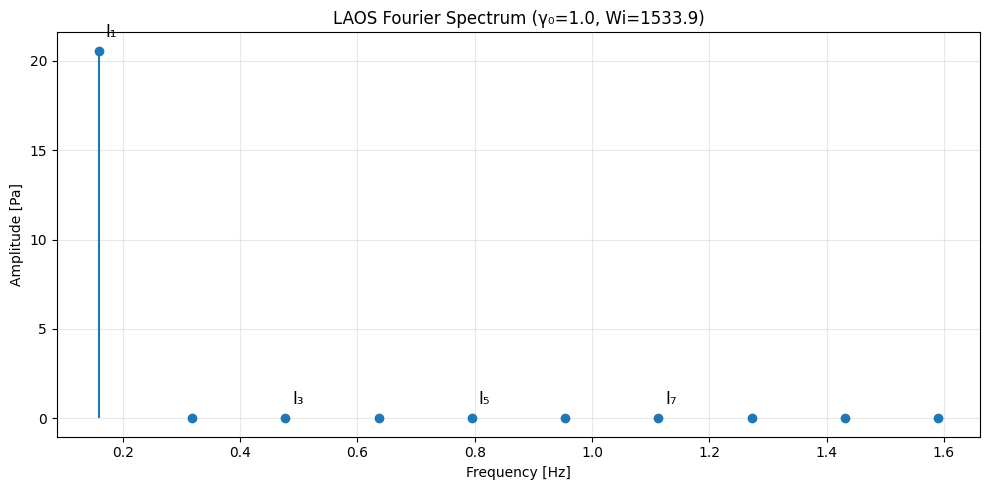

In [10]:
# Plot FFT spectrum
fig, ax = plt.subplots(figsize=(10, 5))

# Only positive frequencies up to 10th harmonic
max_freq = 10 * fundamental_freq
pos_mask = (freqs > 0) & (freqs < max_freq)

amplitudes = 2 * np.abs(stress_fft) / n

ax.stem(freqs[pos_mask], amplitudes[pos_mask], basefmt=" ")

# Mark harmonics
for h, label in [(1, "I₁"), (3, "I₃"), (5, "I₅"), (7, "I₇")]:
    h_freq = h * fundamental_freq
    h_idx = np.argmin(np.abs(freqs - h_freq))
    ax.annotate(label, (freqs[h_idx], amplitudes[h_idx]), 
                xytext=(5, 10), textcoords="offset points", fontsize=12)

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Amplitude [Pa]")
ax.set_title(f"LAOS Fourier Spectrum (γ₀={gamma_0}, Wi={Wi:.1f})")
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Effect of Strain Amplitude on Nonlinearity

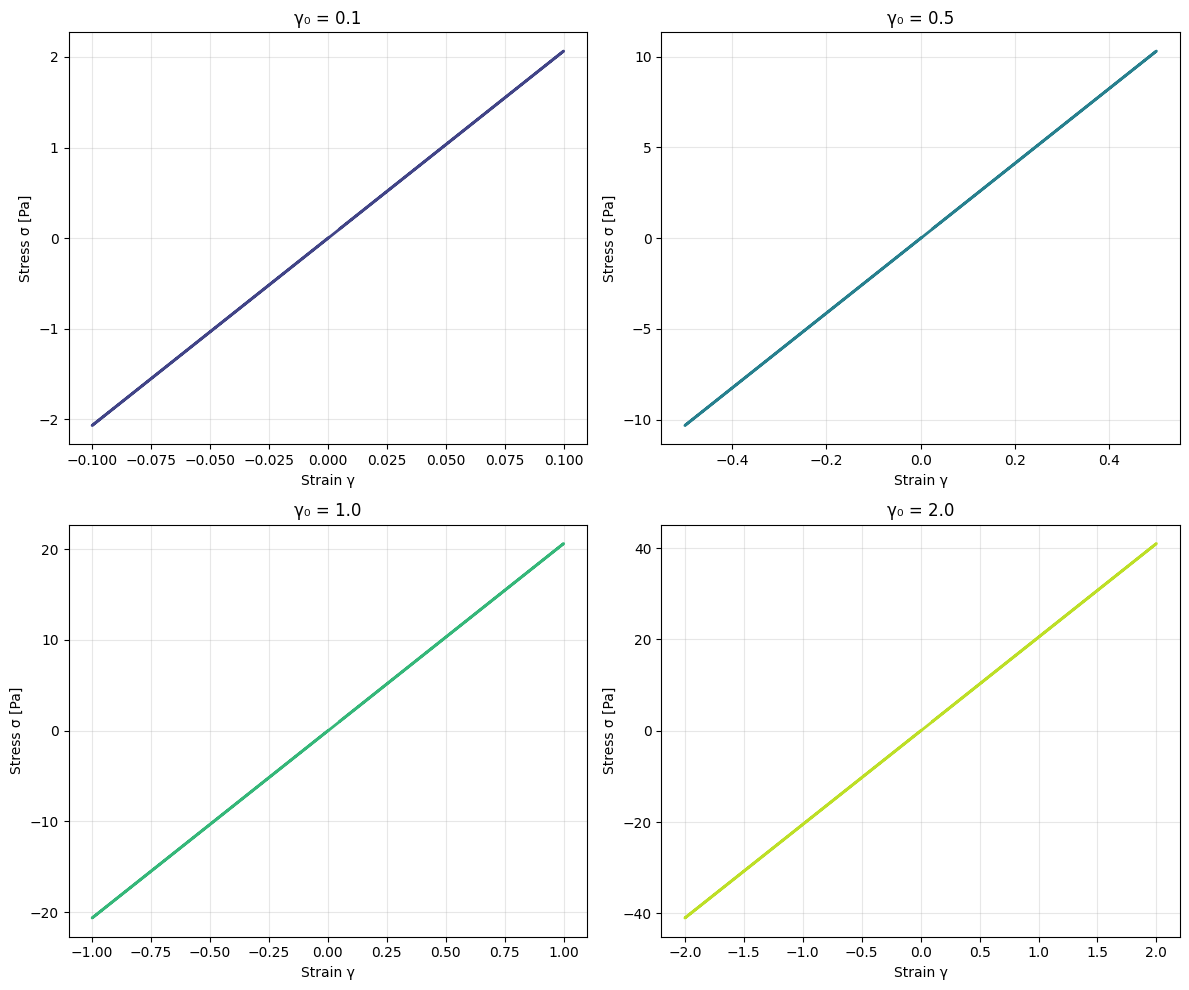


I₃/I₁ vs strain amplitude:
  γ₀ = 0.1: I₃/I₁ = 0.0013
  γ₀ = 0.5: I₃/I₁ = 0.0013
  γ₀ = 1.0: I₃/I₁ = 0.0013
  γ₀ = 2.0: I₃/I₁ = 0.0013


In [11]:
# Compare different strain amplitudes
gamma_0_values = [0.1, 0.5, 1.0, 2.0]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(gamma_0_values)))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

I3_I1_list = []

for i, g0 in enumerate(gamma_0_values):
    # Simulate
    n_cyc = 5  # Fewer cycles for speed
    per = 2 * np.pi / omega
    t = np.linspace(0.01, n_cyc * per, n_cyc * 100)
    
    result_i = model.simulate_laos(t, gamma_0=g0, omega=omega, n_cycles=n_cyc)
    if isinstance(result_i, dict):
        stress_i = np.array(result_i.get("stress", result_i.get("sigma", np.zeros_like(t))))
    else:
        stress_i = np.array(result_i)
    if len(stress_i) != len(t):
        stress_i = np.interp(t, np.linspace(0, n_cyc * per, len(stress_i)), stress_i)
    
    # Strain
    strain_i = g0 * np.sin(omega * t)
    
    # Last cycle for Lissajous
    mask = t >= (n_cyc - 1) * per
    
    # Lissajous
    ax_row = i // 2
    ax_col = i % 2
    ax = axes[ax_row, ax_col]
    ax.plot(strain_i[mask], stress_i[mask], "-", lw=2, color=colors[i])
    ax.set_xlabel("Strain γ")
    ax.set_ylabel("Stress σ [Pa]")
    ax.set_title(f"γ₀ = {g0}")
    ax.grid(True, alpha=0.3)
    
    # FFT for I3/I1
    stress_cyc = stress_i[-100:]
    stress_fft_i = fft(stress_cyc)
    n_pts = len(stress_cyc)
    amps = 2 * np.abs(stress_fft_i) / n_pts
    I1_i = amps[1] if len(amps) > 1 else 1.0
    I3_i = amps[3] if len(amps) > 3 else 0.0
    I3_I1_list.append(I3_i / I1_i if I1_i > 0 else 0)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nI₃/I₁ vs strain amplitude:")
for g0, ratio in zip(gamma_0_values, I3_I1_list):
    print(f"  γ₀ = {g0}: I₃/I₁ = {ratio:.4f}")

## 8. Effect of α on LAOS

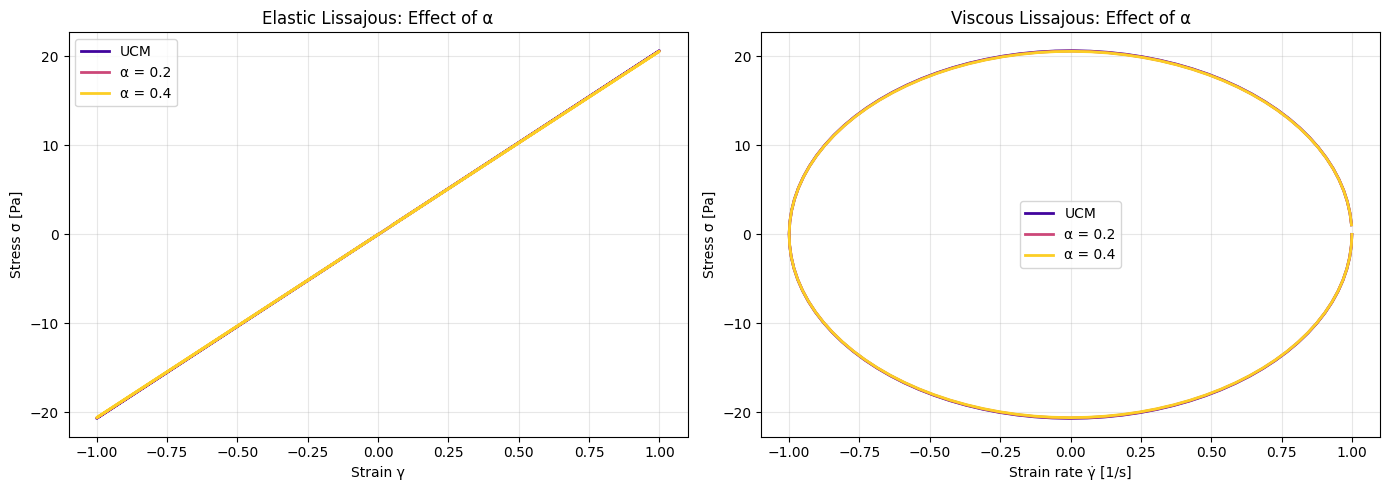

In [12]:
# Compare different α values at fixed γ₀ = 1
alpha_values = [0.0, 0.2, 0.4]
colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(alpha_values)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i, alpha_i in enumerate(alpha_values):
    model_i = GiesekusSingleMode()
    model_i.parameters.set_value("eta_p", calibrated_params["eta_p"])
    model_i.parameters.set_value("lambda_1", calibrated_params["lambda_1"])
    model_i.parameters.set_value("alpha", alpha_i)
    model_i.parameters.set_value("eta_s", calibrated_params["eta_s"])
    
    # Simulate
    n_cyc = 5
    per = 2 * np.pi / omega
    t = np.linspace(0.01, n_cyc * per, n_cyc * 100)
    
    result_i = model_i.simulate_laos(t, gamma_0=1.0, omega=omega, n_cycles=n_cyc)
    if isinstance(result_i, dict):
        stress_i = np.array(result_i.get("stress", result_i.get("sigma", np.zeros_like(t))))
    else:
        stress_i = np.array(result_i)
    if len(stress_i) != len(t):
        stress_i = np.interp(t, np.linspace(0, n_cyc * per, len(stress_i)), stress_i)
    
    strain_i = 1.0 * np.sin(omega * t)
    strain_rate_i = 1.0 * omega * np.cos(omega * t)
    
    mask = t >= (n_cyc - 1) * per
    
    label = "UCM" if alpha_i == 0 else f"α = {alpha_i}"
    ax1.plot(strain_i[mask], stress_i[mask], "-", lw=2, color=colors[i], label=label)
    ax2.plot(strain_rate_i[mask], stress_i[mask], "-", lw=2, color=colors[i], label=label)

ax1.set_xlabel("Strain γ")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title("Elastic Lissajous: Effect of α")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Strain rate γ̇ [1/s]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title("Viscous Lissajous: Effect of α")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 9. Save Results

In [13]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "laos")
os.makedirs(output_dir, exist_ok=True)

# Save LAOS parameters and harmonics
laos_results = {
    "gamma_0": float(gamma_0),
    "omega": float(omega),
    "Wi": float(Wi),
    "De": float(De),
    "I1": float(I1),
    "I3": float(I3),
    "I5": float(I5),
    "I3_I1": float(I3 / I1),
    "I5_I1": float(I5 / I1),
    "alpha": float(alpha),
}
with open(os.path.join(output_dir, "laos_harmonics.json"), "w") as f:
    json.dump(laos_results, f, indent=2)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/giesekus/laos/


## Key Takeaways

1. **LAOS probes nonlinear viscoelasticity** through higher harmonics and Lissajous distortion.

2. **Odd harmonics** (I₃, I₅, ...) arise from material nonlinearity. Even harmonics indicate asymmetry or experimental artifacts.

3. **I₃/I₁ ratio** is a measure of nonlinearity:
   - I₃/I₁ < 1% → linear regime
   - I₃/I₁ > 5% → significant nonlinearity

4. **α affects LAOS signatures**:
   - Higher α → more pronounced third harmonic
   - UCM (α=0) shows weaker nonlinearity than Giesekus

5. **Lissajous curves** provide intuitive visualization:
   - Ellipse = linear
   - Distorted ellipse = mild nonlinearity
   - S-shape or figure-8 = strong nonlinearity

### LAOS Analysis Methods

| Method | What It Measures |
|--------|------------------|
| Fourier Transform | Harmonic amplitudes (I₁, I₃, I₅) |
| Chebyshev | Elastic/viscous decomposition (e₁, v₁, e₃, v₃) |
| SPP (Sequence of Physical Processes) | Time-resolved moduli |
| Lissajous-Bowditch | Visual nonlinearity fingerprint |

### This Completes the Giesekus Tutorial Suite

You have now covered all 6 rheological protocols:
1. **Flow curve** (NB01) - Steady shear, α from shear-thinning
2. **SAOS** (NB02) - Linear regime, relaxation time λ
3. **Startup** (NB03) - Stress overshoot, transient nonlinearity
4. **Normal stresses** (NB04) - N₂/N₁ = -α/2
5. **Creep** (NB05) - Strain under constant stress
6. **Relaxation** (NB06) - Faster-than-Maxwell decay
7. **LAOS** (NB07) - Nonlinear oscillatory response